Source
- Scraping Twitter: https://github.com/JustAnotherArchivist/snscrape/tree/master/snscrape
- SNScrape + Tweepy: https://medium.com/@jcldinco/downloading-historical-tweets-using-tweet-ids-via-snscrape-and-tweepy-5f4ecbf19032
- Twitter Scraper (Does not work): https://github.com/taspinar/twitterscraper
- Tweet Preprocessing: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing
- Sentiment Analysis: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082


## Bitcoin

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os

from newsapi_help_func import *
%load_ext autoreload
%autoreload 2

#Corex Setup
# Install CorEx 
# !pip install corextopic
# !pip install networkx

# Import other packages for examples
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import pandas as pd
import numpy as np
import json

from collections import Counter
from gensim.parsing.preprocessing import remove_stopwords
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import re, string, unicodedata
import nltk
from nltk import ngrams, word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords, words
from nltk.stem import LancasterStemmer, WordNetLemmatizer
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
# !pip install ekphrasis
# !pip install tweet-preprocessor
import preprocessor as p
from pyemd import emd

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import tweepy

import scattertext as st

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from string import punctuation

import spacy
from spacy import displacy
from spacy.symbols import amod
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

#For Sentiment Analysis
from textblob import TextBlob
from wordcloud import WordCloud
plt.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Key Dates:
- March 10-11, 2020: Before Price Dump
- March 12, 2020: Bitcoin Price Dump
- March 13-14, 2020: After Price Dump

In [44]:
!snscrape twitter-search "#Bitcoin since:2020-03-10 until:2020-03-11" > btc_tweets_beforedump_mar20.txt

API Keys from Twitter Developer Account: Exported to environment 

Source: https://developer.twitter.com/en/docs/authentication/guides/authentication-best-practices

In [225]:
consumer_key = os.environ.get("CONSUMER_KEY")
consumer_secret = os.environ.get("CONSUMER_SECRET")
access_token = os.environ.get("ACCESS_TOKEN") 
access_token_secret = os.environ.get("ACCESS_SECRET")
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

 Open .txt or .json using pandas.read_json or pandas.read_csv

In [45]:
tweet_url = pd.read_csv("./data/btc_tweets_beforedump_mar20.txt", index_col= None, header = None, names = ["links"])
tweet_url

links
0      https://twitter.com/Crypto_BitC/status/1237528...
1      https://twitter.com/TheBitcoinPizza/status/123...
2      https://twitter.com/PdqJones/status/1237528345...
3      https://twitter.com/Cooriah/status/12375283007...
4      https://twitter.com/sideagoal/status/123752828...
...                                                  ...
11534  https://twitter.com/status_crypto/status/12371...
11535  https://twitter.com/satparity/status/123716628...
11536  https://twitter.com/CryptoTopCharts/status/123...
11537  https://twitter.com/morocotacoin/status/123716...
11538  https://twitter.com/tecminera/status/123716627...

[11539 rows x 1 columns]

 Extract tweet_id using .split function

In [46]:
af = lambda x: x["links"].split("/")[-1]
tweet_url['id'] = tweet_url.apply(af, axis=1)
tweet_url.head()

links                   id
0  https://twitter.com/Crypto_BitC/status/1237528...  1237528463629676544
1  https://twitter.com/TheBitcoinPizza/status/123...  1237528438921035776
2  https://twitter.com/PdqJones/status/1237528345...  1237528345346101254
3  https://twitter.com/Cooriah/status/12375283007...  1237528300710268928
4  https://twitter.com/sideagoal/status/123752828...  1237528284876791808

Convert tweet_url Series into list

In [47]:
ids = tweet_url['id'].tolist()

Issue looping through all ids, the API is giving an error. Therefore, process the ids by batch or chunks

In [48]:
total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

Create function that would extract all elements that we need from the tweet (username, date and the tweet). Add hashtags???

In [49]:
def fetch_tw(ids):
    list_of_tw_status = api.statuses_lookup(ids, tweet_mode= "extended")
    empty_data = pd.DataFrame()
    for status in list_of_tw_status:
            tweet_elem = {"tweet_id": status.id,
                     "screen_name": status.user.screen_name,
                     "tweet":status.full_text,
                     "date":status.created_at}
            empty_data = empty_data.append(tweet_elem, ignore_index = True)
    empty_data.to_csv("./data/btc_tweets_beforedump_mar20.csv", mode="a")

Create another for loop to loop into our batches while processing 50 entries every loop. (That felt like a tongue twister)

In [61]:
for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch)

In [155]:
df_tweets = pd.read_csv('./data/btc_tweets_beforedump_mar20.csv',
                 lineterminator='\n')

In [156]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'], errors='coerce')

In [157]:
df_tweets.sort_values('date')

Unnamed: 0                date      screen_name  \
11761        31.0 2020-03-10 00:00:00  CryptoTopCharts   
11747        17.0 2020-03-10 00:00:00        tecminera   
11748        18.0 2020-03-10 00:00:00     morocotacoin   
11731         1.0 2020-03-10 00:00:01        satparity   
11757        27.0 2020-03-10 00:00:01   CryptoNetDaily   
...           ...                 ...              ...   
11525         NaN                 NaT      screen_name   
11576         NaN                 NaT      screen_name   
11627         NaN                 NaT      screen_name   
11678         NaN                 NaT      screen_name   
11729         NaN                 NaT      screen_name   

                                                   tweet  \
11761  Top50 #Cryptocurrency IN/OUT update in last 12...   
11747  Ahora, parece que un brote de #coronavirus ha ...   
11748  ➡️ ¿Quiere saber cómo vender sus bitcoins en L...   
11731  1 cent = 125 sats #satparity #bitcoin #stackin...   
11757  New #Crypto Daily Candle! 🕯️\nPrices at the cl...   
...                                                  ...   
11525                                              tweet   
11576                                              tweet   
11627                                              tweet   
11678                                              tweet   
11729                                              tweet   

                     tweet_id  
11761  1.2371662773676073e+18  
11747  1.2371662763440824e+18  
11748  1.2371662764700836e+18  
11731  1.2371662812515697e+18  
11757  1.2371662822581207e+18  
...                       ...  
11525                tweet_id  
11576                tweet_id  
11627                tweet_id  
11678                tweet_id  
11729                tweet_id  

[11769 rows x 5 columns]

In [158]:
df_tweets.dtypes

Unnamed: 0            float64
date           datetime64[ns]
screen_name            object
tweet                  object
tweet_id               object
dtype: object

## Tweet Preprocessing 
Since we are dealing with tweets in this competition, we need to do specific tweet text cleaning along with normal text pre-processing. A tweet may contain:
- URL's
- Mentions
- Hashtags
- Emojis
- Smileys
- Spefic words etc.

To clean the tweet , we can use a python library tweet-preprocessor instead of writing the cleaning logic ourself.

Source: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing

Apply tweet preprocessing first. Defining a preprocess function and using pandas apply to apply it on each value of 'text'. 

Preprocessing:
- Lowercasing
- Punctuation Removal
- Replace extra white spaces
- Stopwords removal
- For stop word removal , i have used gensim library

In [159]:
df_tweets['hashtag'] = df_tweets.tweet.apply(lambda x: re.findall(r"#(\w+)", x))
df_tweets['emojis'] = df_tweets.tweet.apply(lambda x: re.findall(r'[^\x00-\x7F]+', x))
df_tweets = df_tweets.dropna()
# df_tweets = df_tweets.drop_duplicates()
df_tweets = df_tweets.drop(['Unnamed: 0', 'tweet_id'], axis=1)

In [160]:
df_tweets.sort_values('date')

date      screen_name  \
11761 2020-03-10 00:00:00  CryptoTopCharts   
11747 2020-03-10 00:00:00        tecminera   
11748 2020-03-10 00:00:00     morocotacoin   
11731 2020-03-10 00:00:01        satparity   
11757 2020-03-10 00:00:01   CryptoNetDaily   
...                   ...              ...   
4     2020-03-10 23:58:29        sideagoal   
43    2020-03-10 23:58:33          Cooriah   
3     2020-03-10 23:58:44         PdqJones   
13    2020-03-10 23:59:06  TheBitcoinPizza   
27    2020-03-10 23:59:12      Crypto_BitC   

                                                   tweet  \
11761  Top50 #Cryptocurrency IN/OUT update in last 12...   
11747  Ahora, parece que un brote de #coronavirus ha ...   
11748  ➡️ ¿Quiere saber cómo vender sus bitcoins en L...   
11731  1 cent = 125 sats #satparity #bitcoin #stackin...   
11757  New #Crypto Daily Candle! 🕯️\nPrices at the cl...   
...                                                  ...   
4      #cerlos - is an eco-friendly, sustainable, hig...   
43     @sqcrypto Does your grant only invite people t...   
3      Support a #Bitcoin developer! Plus, gain a fre...   
13     The #BitcoinPizza would be worth US$79,097,293...   
27     Hey @elonmusk , how about mining $BTC #Bitcoin...   

                                                 hashtag             emojis  
11761         [Cryptocurrency, crypto, bitcoin, altcoin]                 []  
11747           [coronavirus, criptomoneda, TM, Bitcoin]                [ú]  
11748                                          [Bitcoin]  [➡️, ¿, ó, í, 🔻🔻]  
11731      [satparity, bitcoin, stackingsats, stacksats]                 []  
11757                                  [Crypto, Bitcoin]               [🕯️]  
...                                                  ...                ...  
4      [cerlos, IEO, STO, Sustainability, Crowdsale, ...                 []  
43                                             [bitcoin]                 []  
3                                              [Bitcoin]                 []  
13                               [BitcoinPizza, Bitcoin]                 []  
27                                             [Bitcoin]                 []  

[11539 rows x 5 columns]

Consider Lemmatizing to shorten words to root; if necessary:

lemmatizer = WordNetLemmatizer()
 
lemmatizer.lemmatize("rocks")

In [161]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text) #clean to normal text removes hashtags and emojis
    text = re.sub(r'[^\w]', ' ', text) #Removes all symbols
    text = text.lower() # lowercases all words
    text = re.sub(r'\d+', '', text) # Removes numbers
    text = re.sub('RT[\s]+', '', text) # Removing RT (Retweet?)
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink

    # my_stop_words = STOPWORDS.union(set(['Bitcoin', 'BTC']))
    text = remove_stopwords(text) #removes stopwords
    text = re.sub(r'\W*\b\w{1,2}\b', '', text) #Removes words between 1 and 2 characters short
    
    return text

df_tweets['tweet'] = df_tweets.apply(preprocess_tweet, axis=1)

df_tweets['tokens'] = df_tweets['tweet'].apply(word_tokenize) 

df_tweets.head()

date     screen_name  \
0 2020-03-10 23:54:09    ne_crypto401   
1 2020-03-10 23:49:53     LOReBitcoin   
2 2020-03-10 23:50:38  AlphaexCapital   
3 2020-03-10 23:58:44        PdqJones   
4 2020-03-10 23:58:29       sideagoal   

                                               tweet  \
0            run halving run halving come bulls aint   
1                                  nuevo video sobre   
2  wanted know swing trader article delve popular...   
3  support developer plus gain fresh unique persp...   
4  eco friendly sustainable high performance buil...   

                                             hashtag       emojis  \
0                                [Litecoin, bitcoin]  [’, ’, 😳😤🙏]   
1               [Bitcoin, Criptomonedas, blockchain]         [😁❤]   
2  [forex, trading, money, forextrading, traders,...           []   
3                                          [Bitcoin]           []   
4  [cerlos, IEO, STO, Sustainability, Crowdsale, ...           []   

                                              tokens  
0    [run, halving, run, halving, come, bulls, aint]  
1                              [nuevo, video, sobre]  
2  [wanted, know, swing, trader, article, delve, ...  
3  [support, developer, plus, gain, fresh, unique...  
4  [eco, friendly, sustainable, high, performance...

In [162]:
df_tweets.sort_values('date')

date      screen_name  \
11761 2020-03-10 00:00:00  CryptoTopCharts   
11747 2020-03-10 00:00:00        tecminera   
11748 2020-03-10 00:00:00     morocotacoin   
11731 2020-03-10 00:00:01        satparity   
11757 2020-03-10 00:00:01   CryptoNetDaily   
...                   ...              ...   
4     2020-03-10 23:58:29        sideagoal   
43    2020-03-10 23:58:33          Cooriah   
3     2020-03-10 23:58:44         PdqJones   
13    2020-03-10 23:59:06  TheBitcoinPizza   
27    2020-03-10 23:59:12      Crypto_BitC   

                                                   tweet  \
11761                          update hours snxout waves   
11747  ahora parece que brote demostrado ser demasiad...   
11748  quiere saber cmo vender sus bitcoins localbitc...   
11731                                          cent sats   
11757  new daily candle prices close btc eth xrp bch ...   
...                                                  ...   
4      eco friendly sustainable high performance buil...   
43     grant invite people specifically work bitcoin ...   
3      support developer plus gain fresh unique persp...   
13                                     worth right hours   
27                                        hey mining btc   

                                                 hashtag             emojis  \
11761         [Cryptocurrency, crypto, bitcoin, altcoin]                 []   
11747           [coronavirus, criptomoneda, TM, Bitcoin]                [ú]   
11748                                          [Bitcoin]  [➡️, ¿, ó, í, 🔻🔻]   
11731      [satparity, bitcoin, stackingsats, stacksats]                 []   
11757                                  [Crypto, Bitcoin]               [🕯️]   
...                                                  ...                ...   
4      [cerlos, IEO, STO, Sustainability, Crowdsale, ...                 []   
43                                             [bitcoin]                 []   
3                                              [Bitcoin]                 []   
13                               [BitcoinPizza, Bitcoin]                 []   
27                                             [Bitcoin]                 []   

                                                  tokens  
11761                     [update, hours, snxout, waves]  
11747  [ahora, parece, que, brote, demostrado, ser, d...  
11748  [quiere, saber, cmo, vender, sus, bitcoins, lo...  
11731                                       [cent, sats]  
11757  [new, daily, candle, prices, close, btc, eth, ...  
...                                                  ...  
4      [eco, friendly, sustainable, high, performance...  
43     [grant, invite, people, specifically, work, bi...  
3      [support, developer, plus, gain, fresh, unique...  
13                                 [worth, right, hours]  
27                                    [hey, mining, btc]  

[11539 rows x 6 columns]

Everything seems cleaned up so now we can move onto Sentiment Analysis.

## Sentiment Analysis

The functions called will add the tweets’ subjectivity and polarity into two columns in the DataFrame. 
- getSubjectivity function: How subjective/opinionated the text is 
    - Score of 0 is fact
    - Score of +1 is very much an opinion 
- getPolarity: How positive or negative the text is
    - Score of -1 is the highest negative score
    - Score of +1 is the highest positive score

Source: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

In [163]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df_tweets['Subjectivity'] = df_tweets['tweet'].apply(getSubjectivity)
df_tweets['Polarity'] = df_tweets['tweet'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df_tweets.sort_values('date')

date      screen_name  \
11761 2020-03-10 00:00:00  CryptoTopCharts   
11747 2020-03-10 00:00:00        tecminera   
11748 2020-03-10 00:00:00     morocotacoin   
11731 2020-03-10 00:00:01        satparity   
11757 2020-03-10 00:00:01   CryptoNetDaily   
...                   ...              ...   
4     2020-03-10 23:58:29        sideagoal   
43    2020-03-10 23:58:33          Cooriah   
3     2020-03-10 23:58:44         PdqJones   
13    2020-03-10 23:59:06  TheBitcoinPizza   
27    2020-03-10 23:59:12      Crypto_BitC   

                                                   tweet  \
11761                          update hours snxout waves   
11747  ahora parece que brote demostrado ser demasiad...   
11748  quiere saber cmo vender sus bitcoins localbitc...   
11731                                          cent sats   
11757  new daily candle prices close btc eth xrp bch ...   
...                                                  ...   
4      eco friendly sustainable high performance buil...   
43     grant invite people specifically work bitcoin ...   
3      support developer plus gain fresh unique persp...   
13                                     worth right hours   
27                                        hey mining btc   

                                                 hashtag             emojis  \
11761         [Cryptocurrency, crypto, bitcoin, altcoin]                 []   
11747           [coronavirus, criptomoneda, TM, Bitcoin]                [ú]   
11748                                          [Bitcoin]  [➡️, ¿, ó, í, 🔻🔻]   
11731      [satparity, bitcoin, stackingsats, stacksats]                 []   
11757                                  [Crypto, Bitcoin]               [🕯️]   
...                                                  ...                ...   
4      [cerlos, IEO, STO, Sustainability, Crowdsale, ...                 []   
43                                             [bitcoin]                 []   
3                                              [Bitcoin]                 []   
13                               [BitcoinPizza, Bitcoin]                 []   
27                                             [Bitcoin]                 []   

                                                  tokens  Subjectivity  \
11761                     [update, hours, snxout, waves]      0.000000   
11747  [ahora, parece, que, brote, demostrado, ser, d...      0.000000   
11748  [quiere, saber, cmo, vender, sus, bitcoins, lo...      0.000000   
11731                                       [cent, sats]      0.000000   
11757  [new, daily, candle, prices, close, btc, eth, ...      0.227273   
...                                                  ...           ...   
4      [eco, friendly, sustainable, high, performance...      0.520000   
43     [grant, invite, people, specifically, work, bi...      0.500000   
3      [support, developer, plus, gain, fresh, unique...      0.547619   
13                                 [worth, right, hours]      0.317857   
27                                    [hey, mining, btc]      0.000000   

       Polarity  
11761  0.000000  
11747  0.000000  
11748  0.000000  
11731  0.000000  
11757  0.068182  
...         ...  
4      0.267500  
43     0.050000  
3      0.201190  
13     0.292857  
27     0.000000  

[11539 rows x 8 columns]

In [164]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_tweets['Analysis'] = df_tweets['Polarity'].apply(getAnalysis)
# Show the dataframe
df_tweets

date     screen_name  \
0     2020-03-10 23:54:09    ne_crypto401   
1     2020-03-10 23:49:53     LOReBitcoin   
2     2020-03-10 23:50:38  AlphaexCapital   
3     2020-03-10 23:58:44        PdqJones   
4     2020-03-10 23:58:29       sideagoal   
...                   ...             ...   
11764 2020-03-10 00:00:30        BtcPulse   
11765 2020-03-10 00:00:23   Bitcoin_Meter   
11766 2020-03-10 00:00:21      btcreports   
11767 2020-03-10 00:00:14       r_topisto   
11768 2020-03-10 00:00:44       tq_crypto   

                                                   tweet  \
0                run halving run halving come bulls aint   
1                                      nuevo video sobre   
2      wanted know swing trader article delve popular...   
3      support developer plus gain fresh unique persp...   
4      eco friendly sustainable high performance buil...   
...                                                  ...   
11764                              btc hourly update btc   
11765  current price status going upnext price status...   
11766                              mar price usd eur jpy   
11767                                 slast block height   
11768          btcusd falls lowest close january neutral   

                                                 hashtag       emojis  \
0                                    [Litecoin, bitcoin]  [’, ’, 😳😤🙏]   
1                   [Bitcoin, Criptomonedas, blockchain]         [😁❤]   
2      [forex, trading, money, forextrading, traders,...           []   
3                                              [Bitcoin]           []   
4      [cerlos, IEO, STO, Sustainability, Crowdsale, ...           []   
...                                                  ...          ...   
11764                                  [BTCUSD, Bitcoin]          [📈]   
11765                                     [Bitcoin, BTC]       [🔸, 🔸]   
11766                                          [Bitcoin]           []   
11767                 [computerart, bitcoin, blockchain]           []   
11768                             [BTCUSD, BTC, Bitcoin]           []   

                                                  tokens  Subjectivity  \
0        [run, halving, run, halving, come, bulls, aint]      0.000000   
1                                  [nuevo, video, sobre]      0.000000   
2      [wanted, know, swing, trader, article, delve, ...      0.900000   
3      [support, developer, plus, gain, fresh, unique...      0.547619   
4      [eco, friendly, sustainable, high, performance...      0.520000   
...                                                  ...           ...   
11764                         [btc, hourly, update, btc]      0.000000   
11765  [current, price, status, going, upnext, price,...      0.544444   
11766                        [mar, price, usd, eur, jpy]      0.000000   
11767                             [slast, block, height]      0.000000   
11768   [btcusd, falls, lowest, close, january, neutral]      0.000000   

       Polarity  Analysis  
0       0.00000   Neutral  
1       0.00000   Neutral  
2       0.60000  Positive  
3       0.20119  Positive  
4       0.26750  Positive  
...         ...       ...  
11764   0.00000   Neutral  
11765   0.10000  Positive  
11766   0.00000   Neutral  
11767   0.00000   Neutral  
11768   0.00000   Neutral  

[11539 rows x 9 columns]

In [165]:
df_tweets.to_csv("./data/btc_tweets_beforedump_mar20_cleaned.csv")

In [167]:
df_tweets = pd.read_csv('./data/btc_tweets_beforedump_mar20_cleaned.csv')
df_tweets = df_tweets.drop(['Unnamed: 0'], axis=1)
df_tweets = df_tweets.dropna()
df_tweets.sort_values('date')

date      screen_name  \
11531  2020-03-10 00:00:00  CryptoTopCharts   
11517  2020-03-10 00:00:00        tecminera   
11518  2020-03-10 00:00:00     morocotacoin   
11503  2020-03-10 00:00:01    status_crypto   
11527  2020-03-10 00:00:01   CryptoNetDaily   
...                    ...              ...   
4      2020-03-10 23:58:29        sideagoal   
43     2020-03-10 23:58:33          Cooriah   
3      2020-03-10 23:58:44         PdqJones   
13     2020-03-10 23:59:06  TheBitcoinPizza   
27     2020-03-10 23:59:12      Crypto_BitC   

                                                   tweet  \
11531                          update hours snxout waves   
11517  ahora parece que brote demostrado ser demasiad...   
11518  quiere saber cmo vender sus bitcoins localbitc...   
11503                                        usd usd usd   
11527  new daily candle prices close btc eth xrp bch ...   
...                                                  ...   
4      eco friendly sustainable high performance buil...   
43     grant invite people specifically work bitcoin ...   
3      support developer plus gain fresh unique persp...   
13                                     worth right hours   
27                                        hey mining btc   

                                                 hashtag  \
11531  ['Cryptocurrency', 'crypto', 'bitcoin', 'altco...   
11517   ['coronavirus', 'criptomoneda', 'TM', 'Bitcoin']   
11518                                        ['Bitcoin']   
11503  ['HourlyCryptoStatus', '1', '3', '1', 'btc', '...   
11527                              ['Crypto', 'Bitcoin']   
...                                                  ...   
4      ['cerlos', 'IEO', 'STO', 'Sustainability', 'Cr...   
43                                           ['bitcoin']   
3                                            ['Bitcoin']   
13                           ['BitcoinPizza', 'Bitcoin']   
27                                           ['Bitcoin']   

                            emojis  \
11531                           []   
11517                        ['ú']   
11518  ['➡️', '¿', 'ó', 'í', '🔻🔻']   
11503                           []   
11527                       ['🕯️']   
...                            ...   
4                               []   
43                              []   
3                               []   
13                              []   
27                              []   

                                                  tokens  Subjectivity  \
11531             ['update', 'hours', 'snxout', 'waves']      0.000000   
11517  ['ahora', 'parece', 'que', 'brote', 'demostrad...      0.000000   
11518  ['quiere', 'saber', 'cmo', 'vender', 'sus', 'b...      0.000000   
11503                              ['usd', 'usd', 'usd']      0.000000   
11527  ['new', 'daily', 'candle', 'prices', 'close', ...      0.227273   
...                                                  ...           ...   
4      ['eco', 'friendly', 'sustainable', 'high', 'pe...      0.520000   
43     ['grant', 'invite', 'people', 'specifically', ...      0.500000   
3      ['support', 'developer', 'plus', 'gain', 'fres...      0.547619   
13                           ['worth', 'right', 'hours']      0.317857   
27                              ['hey', 'mining', 'btc']      0.000000   

       Polarity  Analysis  
11531  0.000000   Neutral  
11517  0.000000   Neutral  
11518  0.000000   Neutral  
11503  0.000000   Neutral  
11527  0.068182  Positive  
...         ...       ...  
4      0.267500  Positive  
43     0.050000  Positive  
3      0.201190  Positive  
13     0.292857  Positive  
27     0.000000   Neutral  

[10009 rows x 9 columns]

# Word Clouds

Let's observe how well the sentiments are distributed by plotting the common words in a word clouds.
- Word cloud (also known as text clouds or tag clouds) is a visualization, the more a specific word appears in the text, the bigger and bolder it appears in the word cloud.

It looks like the words "participate" and "amazing" appear a lot for Bitcoins past 14,000+ tweets.

In [168]:
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

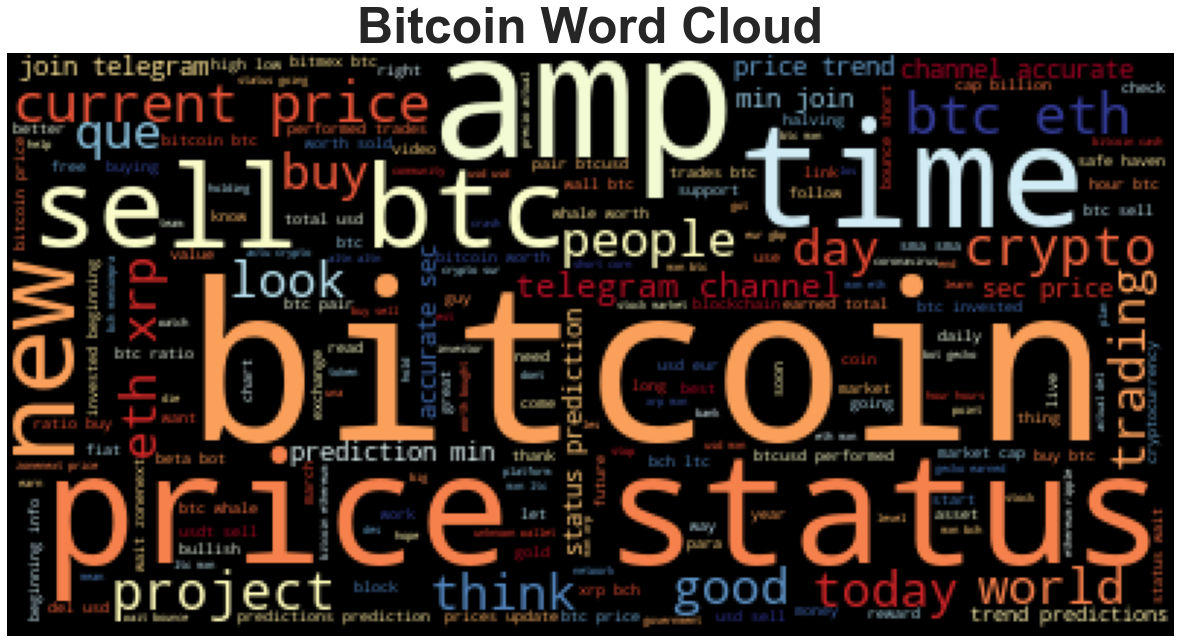

In [81]:
# Generate the Bitcoin word cloud
allWords = ' '.join([twts for twts in df_tweets['tweet']])
wordcloud = WordCloud(colormap="RdYlBu").generate(allWords)
plt.imshow(wordcloud)
plt.axis("off")
fontdict = {"fontsize": 50, "fontweight": "bold"}
plt.title("Bitcoin Word Cloud", fontdict=fontdict)
plt.show()

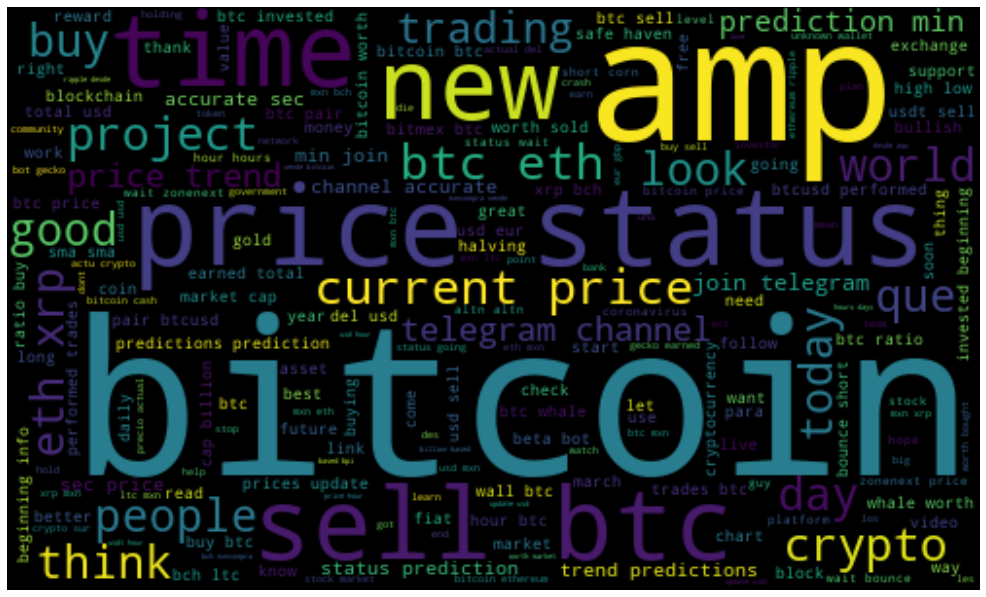

In [169]:
# word cloud visualization and potentially combine hashtags? 
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Function below computes the negative (-1), neutral (0), and positive (+1) analysis, and adds it to a new column called Analysis

Prints the positive tweets in ascending order. The most positive tweet is the #1 tweet.

In [170]:
# Printing positive tweets 
print('Printing positive tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['tweet'][i])
        print()
        j= j+1

Printing positive tweets:

1) wanted know swing trader article delve popular trading styles benefit

2) support developer plus gain fresh unique perspective value truly scarce resources limited time earth number bitcoin exist

3) eco friendly sustainable high performance building material mold rot insect resistant

4) current price status wait zonenext price status prediction min join telegram channel accurate sec price trend predictions prediction

5) worth right hours

6) dlive originally built steem blockchain popular users steemit platform migrating lino network prior tron migration



KeyError: 15

Prints the negative tweets in ascending order. The most negative tweet is the #1 tweet.

In [171]:
# Printing negative tweets  
print('Printing negative tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+sortedDF['tweet'][i])
        print()
        j=j+1

Printing negative tweets:



KeyError: 15

### Fix statement below
Plot the polarity and subjectivity as a scatter plot. It looks like the majority of the tweets are positive, as many of the points are on the right side of the polarity at value 0.00.

Print the percentage of positive tweets. About 43.6% of the tweets are considered positive tweets.

In [172]:
# Print the percentage of positive tweets
ptweets = df_tweets[df_tweets.Analysis == 'Positive']
ptweets = ptweets['tweet']
ptweets

round( (ptweets.shape[0] / df_tweets.shape[0]) * 100 , 1)

31.0

Print the percentage of negative tweets. About 5.2% of the tweets are considered negative tweets.

In [173]:
# Print the percentage of negative tweets
ntweets = df_tweets[df_tweets.Analysis == 'Negative']
ntweets = ntweets['tweet']
ntweets

round( (ntweets.shape[0] / df_tweets.shape[0]) * 100, 1)

9.0

In [174]:
# Show the value counts
df_tweets['Analysis'].value_counts()

Neutral     6013
Positive    3099
Negative     897
Name: Analysis, dtype: int64

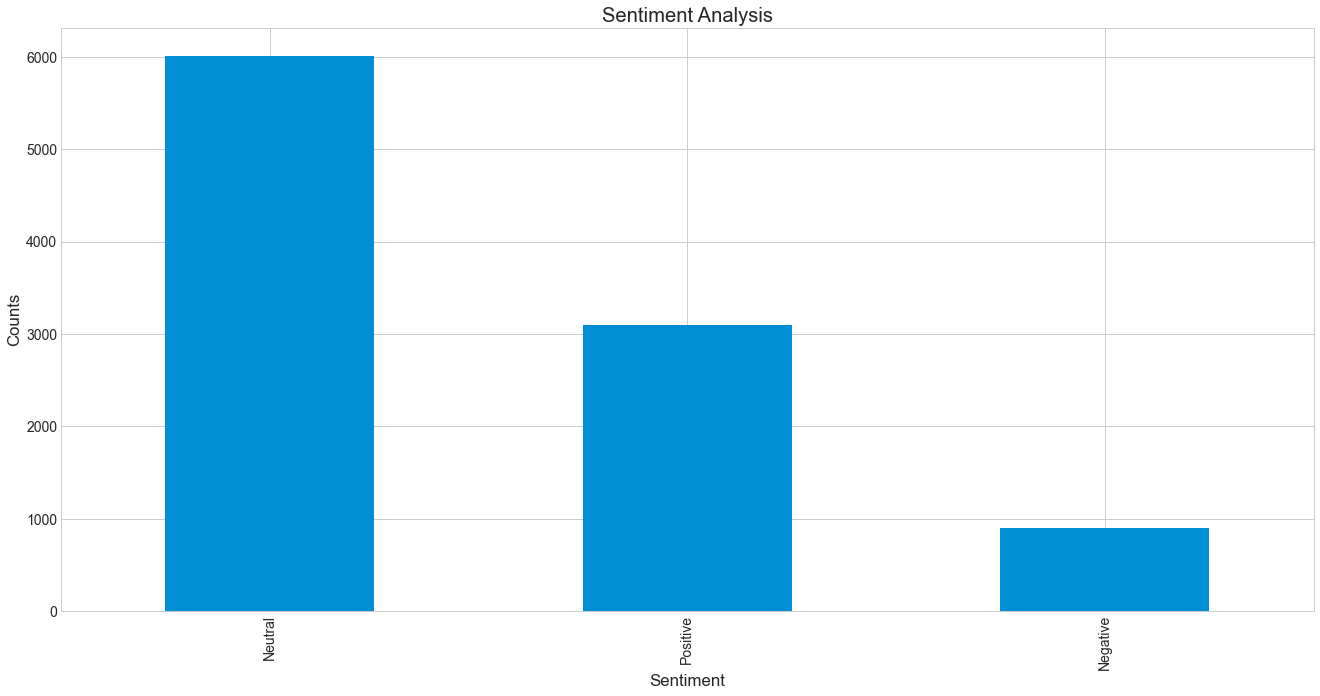

In [175]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_tweets['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

## Bitcoin NER

In [88]:
# Concatenate all of the bitcoin text together
flat_btc_text_str = " ".join(df_tweets.tweet.to_list())
print(flat_btc_text_str)

despite longer having worth portfolio current alts skin game bought lol coming soon btcjpy current price status going upnext price status prediction min join telegram channel accurate sec price trend predictions prediction current price status going upnext price status prediction min join telegram channel accurate sec price trend predictions prediction damn obvious banks governments partnered ripple ripplenet home ripple introduces revolutionary product connecting clients libra association member offers explanation crypto market decline xbt usdi remember exact techniques measured moves correctly short term potentially form bounce long  amp today long world losing shit hahahahahah shit stocks shit dollars ownership beats debt nation currencies disaster bitcoin daily seeks regulate crypto ubi sounds phenomenal tim xemusd falling wedge forex trader ultimate guide beginners talking stock market crash oil prices plummeting dumping talking real topics like anniversary death price changes hou

In [89]:
# Run the NER processor on all of the text
btc_doc = nlp(flat_btc_text_str)
btc_doc.user_data["title"] = "Bitcoin NER"
# Add a title to the document

In [90]:
# Render the visualization
displacy.render(btc_doc,style='ent')

spaCy tokenizes text in an entirely nondestructive manner... The underlying text does not change... spaCy does not explicitly break the original text into a list, but tokens can be accessed by index span.

spaCy provides syntactic parsing to show word usage, thus creating a dependency tree

In [92]:
for token in btc_doc:
    if token.dep_ == 'amod':
        print(f"ADJ MODIFIER: {token.text} --> NOUN: {token.head}")

interested --> NOUN: attempts
ADJ MODIFIER: devoted --> NOUN: rewards
ADJ MODIFIER: great --> NOUN: rewards
ADJ MODIFIER: arrive --> NOUN: darkness
ADJ MODIFIER: long --> NOUN: opportunity
ADJ MODIFIER: mda --> NOUN: opportunity
ADJ MODIFIER: latest --> NOUN: sources
ADJ MODIFIER: global --> NOUN: sources
ADJ MODIFIER: real --> NOUN: time
ADJ MODIFIER: grateful --> NOUN: devotion
ADJ MODIFIER: early --> NOUN: days
ADJ MODIFIER: light --> NOUN: blocks
ADJ MODIFIER: insignificant --> NOUN: blocks
ADJ MODIFIER: bitcoin --> NOUN: data
ADJ MODIFIER: daily --> NOUN: profit
ADJ MODIFIER: updated --> NOUN: hour
ADJ MODIFIER: looking --> NOUN: schiff
ADJ MODIFIER: schiff --> NOUN: calls
ADJ MODIFIER: horrible --> NOUN: calls
ADJ MODIFIER: historical --> NOUN: calls
ADJ MODIFIER: prior --> NOUN: calls
ADJ MODIFIER: historical --> NOUN: calls
ADJ MODIFIER: biggest --> NOUN: gold
ADJ MODIFIER: glorious --> NOUN: chest
ADJ MODIFIER: divisible --> NOUN: draw
ADJ MODIFIER: vertical --> NOUN: infiniti

### Named Entity Recognition
To see which tokens spaCy identifies as named entities... simply cycle through `btc_doc.ents`"

In [93]:
for ent in btc_doc.ents:
    print(ent.text, ent.label_)


josema estamos PERSON
viviendo algo PERSON
completo china stock markets ORG
bpi ORG
join btc cos phb stx PERSON
nas blz xem snt wan PERSON
vib evx PERSON
bmarket cap bitcoin PERSON
pool day DATE
million CARDINAL
digital trust ORG
pool week EVENT
pool week EVENT
today DATE
pool month DATE
pool month DATE
fiat launch exchange ORG
month DATE
dnn arkasndaki nedenler PERSON
bitcoinin son PERSON
arkasnda hangi PERSON
del usd mxn ORG
btc mxn eth mxn xrp mxn ltc PERSON
hours TIME
hourly TIME
nuovo post ORG
new zealand GPE
day DATE
tak sedikit PERSON
analis NORP
berulang kali menggambarkan PERSON
kemampuannya untuk PERSON
pasar telah PERSON
yaklaan btc usd amp PERSON
araclyla PERSON
farif PERSON
months DATE
revamps proposal PERSON
tom lee PERSON
hedgethomas lee PERSON
tomorrow DATE
morning TIME
sec ORG
vix ORG
march DATE
atom xtz PERSON
knc algo kava PERSON
latest week DATE
seconds TIME
tuesday DATE
midday TIME
today DATE
usd hour TIME
eur ltc PERSON
xlm slt atom PERSON
ada kcs PERSON
xrp PERS

In [176]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_tweets['tweet'], df_tweets['Analysis'], test_size=0.3, random_state=42)

In [177]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
# min_df sets parameter for columns with minimum amount of values
cv1 = CountVectorizer(stop_words='english', min_df=3)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

X_train_cv1_df = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()
X_train_cv1_df

#these words need to be removed!!!

aan  aapl  aave  abd  ability  able  absolutely  accept  accepted  \
0    0     0     0    0        0     0           0       0         0   
1    0     0     0    0        0     0           0       0         0   
2    0     0     0    0        0     0           0       0         0   
3    0     0     0    0        0     0           0       0         0   
4    0     0     0    0        0     0           0       0         0   

   accepting  ...  zero  zil  zirp  zona  zone  zonenext  zoom  zorluu  zrx  \
0          0  ...     0    0     0     0     0         0     0       0    0   
1          0  ...     0    0     0     0     0         1     0       0    0   
2          0  ...     2    0     1     0     0         0     0       0    0   
3          0  ...     0    0     0     0     0         0     0       0    0   
4          0  ...     0    0     0     0     0         0     0       0    0   

   zum  
0    0  
1    0  
2    0  
3    0  
4    0  

[5 rows x 3395 columns]

In [178]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english', min_df=3)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

X_train_cv2_df = pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()
X_train_cv2_df

aan  aapl  aave  abd  ability  able  absolutely  accept  accepted  \
0    0     0     0    0        0     0           0       0         0   
1    0     0     0    0        0     0           0       0         0   
2    0     0     0    0        0     0           0       0         0   
3    0     0     0    0        0     0           0       0         0   
4    0     0     0    0        0     0           0       0         0   

   accepting  ...  zil  zirp  zona  zone  zonenext  zonenext price  zoom  \
0          0  ...    0     0     0     0         0               0     0   
1          0  ...    0     0     0     0         1               1     0   
2          0  ...    0     1     0     0         0               0     0   
3          0  ...    0     0     0     0         0               0     0   
4          0  ...    0     0     0     0         0               0     0   

   zorluu  zrx  zum  
0       0    0    0  
1       0    0    0  
2       0    0    0  
3       0    0    0  
4       0    0    0  

[5 rows x 5242 columns]

### TF-IDF

In [179]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
# min_df parameter sets minimum amount/column
tfidf1 = TfidfVectorizer(stop_words='english',min_df=0.0003)
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

pd.DataFrame(X_train_tfidf1.toarray(), columns=tfidf1.get_feature_names()).head()

aan  aapl  aave  abd  ability  able  absolutely  accept  accepted  \
0  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   
1  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   
2  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   
3  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   
4  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   

   accepting  ...      zero  zil      zirp  zona  zone  zonenext  zoom  \
0        0.0  ...  0.000000  0.0  0.000000   0.0   0.0  0.000000   0.0   
1        0.0  ...  0.000000  0.0  0.000000   0.0   0.0  0.247483   0.0   
2        0.0  ...  0.423708  0.0  0.257608   0.0   0.0  0.000000   0.0   
3        0.0  ...  0.000000  0.0  0.000000   0.0   0.0  0.000000   0.0   
4        0.0  ...  0.000000  0.0  0.000000   0.0   0.0  0.000000   0.0   

   zorluu  zrx  zum  
0     0.0  0.0  0.0  
1     0.0  0.0  0.0  
2     0.0  0.0  0.0  
3     0.0  0.0  0.0  
4     0.0  0.0  0.0  

[5 rows x 3395 columns]

In [180]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english', min_df=0.0003)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

pd.DataFrame(X_train_tfidf2.toarray(), columns=tfidf2.get_feature_names()).head()

aan  aapl  aave  abd  ability  able  absolutely  accept  accepted  \
0  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   
1  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   
2  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   
3  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   
4  0.0   0.0   0.0  0.0      0.0   0.0         0.0     0.0       0.0   

   accepting  ...  zil      zirp  zona  zone  zonenext  zonenext price  zoom  \
0        0.0  ...  0.0  0.000000   0.0   0.0  0.000000        0.000000   0.0   
1        0.0  ...  0.0  0.000000   0.0   0.0  0.212512        0.212512   0.0   
2        0.0  ...  0.0  0.301362   0.0   0.0  0.000000        0.000000   0.0   
3        0.0  ...  0.0  0.000000   0.0   0.0  0.000000        0.000000   0.0   
4        0.0  ...  0.0  0.000000   0.0   0.0  0.000000        0.000000   0.0   

   zorluu  zrx  zum  
0     0.0  0.0  0.0  
1     0.0  0.0  0.0  
2     0.0  0.0  0.0  
3     0.0  0.0  0.0  
4     0.0  0.0  0.0  

[5 rows x 5242 columns]

## Topic Modeling with Matrix Factorization
### Latent Semantic Analysis (LSA)

Sklearn's TruncatedSVD is designed to perform singular value decomposition on a count vectorizer or TF-IDF vectorizer object. Read up on the [documentation](https://scikit-learn.org/stable/modules/decomposition.html), which also discusses NMF and LDA.

> TruncatedSVD is very similar to PCA, but differs in that the matrix *X* does not need to be centered. When the columnwise (per-feature) means of *X* are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA. In practical terms, this means that the TruncatedSVD transformer accepts scipy.sparse matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections.

> While the TruncatedSVD transformer works with any feature matrix, using it on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting. In particular, sublinear scaling and inverse document frequency should be turned on (sublinear_tf=True, use_idf=True) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.

In [181]:
# Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(3)
btc_doc_topic = lsa.fit_transform(X_train_cv1)
lsa.explained_variance_ratio_

array([0.04625726, 0.04696362, 0.0268952 ])

The U matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:

In [182]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2",'component_3'],
             columns = cv1.get_feature_names())
topic_word

aan   aapl  aave  abd  ability   able  absolutely  accept  \
component_1  0.000  0.001   0.0  0.0      0.0  0.001       0.001   0.001   
component_2 -0.000 -0.000  -0.0 -0.0     -0.0  0.000      -0.000   0.000   
component_3  0.002  0.000   0.0  0.0      0.0  0.000      -0.000   0.001   

             accepted  accepting  ...   zero    zil  zirp  zona   zone  \
component_1       0.0      0.001  ...  0.001  0.001   0.0   0.0  0.003   
component_2       0.0     -0.000  ... -0.000  0.000   0.0  -0.0  0.000   
component_3       0.0      0.000  ... -0.000  0.001   0.0   0.0 -0.000   

             zonenext   zoom  zorluu    zrx  zum  
component_1     0.015  0.000   0.000  0.001  0.0  
component_2     0.072  0.000  -0.000  0.000 -0.0  
component_3    -0.008  0.001   0.001  0.000  0.0  

[3 rows x 3395 columns]

In [183]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [184]:
display_topics(lsa, cv1.get_feature_names(), 5)


Topic  0
btc, sell, price, usd, bitcoin

Topic  1
price, prediction, status, current, join

Topic  2
mxn, bitcoin, eth, bch, usd


The Vt matrix shows us the documents we started with, and how each document is made up of the # resulting topics. In this case:
- Topic 0: Sell bitcoin at current price 
- Topic 1: Current price status 
- Topic 2: Different cryptocurrencies

In [120]:
Vt = pd.DataFrame(btc_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2","component_3" ])
Vt

component_1  component_2  \
tweet                                                                          
automated manufacturing                                 0.00000     -0.00000   
current price status wait zonenext price status...      1.34389      4.94562   
years zirp world zero rate policy fed started u...      0.03720      0.01124   
peak btc volume trading major exchanges price t...      1.10487      0.41545   
ouroboros hydra revolutionary development look ...      0.96243     -0.26312   
...                                                         ...          ...   
bitcoin worth market cap billion based bpi              0.24211      0.02820   
hardware bitcoin wallet trezor eur                      0.19895      0.03370   
think youre confusing wife                              0.00618      0.00093   
 atalantaover retweet                                   0.00161     -0.00011   
karlai kaip laikosi auksas kas toks nagi bitcoi...      0.15356      0.02540   

                                                    component_3  
tweet                                                            
automated manufacturing                                -0.00000  
current price status wait zonenext price status...     -0.30401  
years zirp world zero rate policy fed started u...      0.04555  
peak btc volume trading major exchanges price t...     -0.20740  
ouroboros hydra revolutionary development look ...      0.00339  
...                                                         ...  
bitcoin worth market cap billion based bpi              0.69456  
hardware bitcoin wallet trezor eur                      0.61427  
think youre confusing wife                              0.00158  
 atalantaover retweet                                  -0.00011  
karlai kaip laikosi auksas kas toks nagi bitcoi...      0.52871  

[7006 rows x 3 columns]

Looking at cosine similarity, you can see that two documents both high in component # will have a similarity of #, and two documents high in different components will have a similarity of #.

In [122]:
cosine_similarity(Vt)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.2984235 , ..., 0.37541798, 0.19906666,
        0.06052303],
       [0.        , 0.2984235 , 1.        , ..., 0.80918732, 0.55391473,
        0.91154633],
       ...,
       [0.        , 0.37541798, 0.80918732, ..., 1.        , 0.92777784,
        0.5088907 ],
       [0.        , 0.19906666, 0.55391473, ..., 0.92777784, 1.        ,
        0.20895652],
       [0.        , 0.06052303, 0.91154633, ..., 0.5088907 , 0.20895652,
        1.        ]])

In [123]:
cos_dtm = cosine_similarity(X_train_cv1_df).round(2)
cos_dtm

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.18, 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.11],
       [0.  , 0.18, 0.  , 1.  , 0.08],
       [0.  , 0.  , 0.11, 0.08, 1.  ]])

### Non-Negative Matrix Factorization (NMF)

In this example, we are going to start with 6 documents that contain many unique words (or features). The goal is to reduce those words down into 3 topics, so that each document can be represented as some combination of the 3 topics. We will be using NMF this time around.

In [124]:
nmf_model = NMF(3)
btc_nmf_doc_topic = nmf_model.fit_transform(X_train_cv1)

The W matrix shows us the 3 resulting topics, and the terms that are associated with each topic. In this case:

In [126]:
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = cv1.get_feature_names())
topic_word_nmf

aan   aapl  aave    abd  ability   able  absolutely  accept  \
component_1  0.001  0.007   0.0  0.002      0.0  0.008       0.007   0.001   
component_2  0.000  0.000   0.0  0.000      0.0  0.002       0.000   0.001   
component_3  0.010  0.003   0.0  0.002      0.0  0.004       0.000   0.009   

             accepted  accepting  ...   zero    zil  zirp  zona   zone  \
component_1     0.000      0.005  ...  0.010  0.002   0.0   0.0  0.020   
component_2     0.000      0.000  ...  0.002  0.003   0.0   0.0  0.006   
component_3     0.003      0.003  ...  0.002  0.005   0.0   0.0  0.004   

             zonenext   zoom  zorluu    zrx    zum  
component_1     0.000  0.000   0.002  0.009  0.002  
component_2     0.519  0.003   0.000  0.005  0.000  
component_3     0.000  0.004   0.004  0.004  0.002  

[3 rows x 3395 columns]

In [127]:
display_topics(nmf_model, cv1.get_feature_names(), 10)


Topic  0
btc, sell, buy, ratio, usd, wall, btcusd, total, beta, pair

Topic  1
price, prediction, status, current, join, channel, trend, predictions, sec, telegram

Topic  2
mxn, bitcoin, usd, eth, bch, ltc, xrp, ethereum, del, ripple


The H matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- Topic 0: Bitcoin sell and buy ratio
- Topic 1: Current price prediction status
- Topic 2: Different types of coins

In [128]:
H = pd.DataFrame(btc_nmf_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2","component_3" ])
H

component_1  component_2  \
tweet                                                                          
automated manufacturing                                 0.00000      0.00000   
current price status wait zonenext price status...      0.00000      0.73106   
years zirp world zero rate policy fed started u...      0.00159      0.00189   
peak btc volume trading major exchanges price t...      0.11856      0.09657   
ouroboros hydra revolutionary development look ...      0.11460      0.00000   
...                                                         ...          ...   
bitcoin worth market cap billion based bpi              0.00000      0.00045   
hardware bitcoin wallet trezor eur                      0.00000      0.00144   
think youre confusing wife                              0.00058      0.00028   
 atalantaover retweet                                   0.00020      0.00003   
karlai kaip laikosi auksas kas toks nagi bitcoi...      0.00000      0.00006   

                                                    component_3  
tweet                                                            
automated manufacturing                                 0.00000  
current price status wait zonenext price status...      0.00000  
years zirp world zero rate policy fed started u...      0.00773  
peak btc volume trading major exchanges price t...      0.00000  
ouroboros hydra revolutionary development look ...      0.03233  
...                                                         ...  
bitcoin worth market cap billion based bpi              0.11438  
hardware bitcoin wallet trezor eur                      0.10166  
think youre confusing wife                              0.00036  
 atalantaover retweet                                   0.00001  
karlai kaip laikosi auksas kas toks nagi bitcoi...      0.08657  

[7006 rows x 3 columns]

## Topic Modeling with sklearn and pyLDAvis

Adapted from [the official pyLDAvis repo demo](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb).

We'll try out [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on the [20 Newsgroups dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) with some simple preprocessing.

In [129]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

(7006, 999)


In [130]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(dtm_tfidf.shape)

(7006, 999)


### Fit the Latent Dirichlet Allocation models

In [131]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

## pyLDAvis

Recall the # categories we extracted:

- Topic 0: Bitcoin sell and buy ratio
- Topic 1: Current price prediction status
- Topic 2: Different types of coins

Let's use [pyLDAvis](http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/) to see our topics, and to see if they match up with our expectations.

* The left panel visualizes the topics as circles in the two-dimensional plane whose centres are determined by computing the Jensen–Shannon divergence between topics, and then by using [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) to project the inter-topic distances onto two dimensions. Each topic’s overall prevalence is encoded using the areas of the circles.

* The right panel depicts a horizontal bar chart whose bars represent the individual terms that are the most useful for interpreting the currently selected topic on the left. A pair of overlaid bars represent both the corpus-wide frequency of a given term as well as the topic-specific frequency of the term.

* The λ slider allows to rank the terms according to term relevance. By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 ). Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic. The suggested “optimal” value of λ is 0.6. [Small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.](http://www.kennyshirley.com/LDAvis/)

In [132]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.316517 -0.088478       1        1  7.964190
9     -0.162435 -0.145363       2        1  7.281624
12     0.042838  0.106540       3        1  7.003672
19     0.051465  0.317535       4        1  6.187755
7      0.288045 -0.072748       5        1  5.666125
3     -0.155227 -0.128957       6        1  5.242006
11    -0.030949  0.133911       7        1  4.858703
15     0.102054 -0.110473       8        1  4.837209
8     -0.158107  0.009700       9        1  4.810936
2      0.079303  0.028812      10        1  4.771516
5     -0.088862 -0.029094      11        1  4.577970
16    -0.203413 -0.013963      12        1  4.441295
6     -0.087704  0.067032      13        1  4.389270
18     0.048890  0.019107      14        1  4.313152
4     -0.090800 -0.021328      15        1  4.287510
1     -0.065997 -0.026747      16        1  4.162818
0      0.072875 -0.234069      17        1  4.063081
17     0.095498  0.184753      18        1  3.831036
14    -0.111390  0.034936      19        1  3.688553
10     0.057401 -0.031106      20        1  3.621579, topic_info=       Term         Freq        Total Category  logprob  loglift
105     btc  1561.000000  1561.000000  Default  30.0000  30.0000
673   price   806.000000   806.000000  Default  29.0000  29.0000
928     usd   516.000000   516.000000  Default  28.0000  28.0000
206  crypto   383.000000   383.000000  Default  27.0000  27.0000
289     eth   318.000000   318.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
222    date    18.999662    97.556173  Topic20  -4.2910   1.6823
673   price    28.923466   806.718778  Topic20  -3.8708  -0.0101
668  precio    17.422889    76.153528  Topic20  -4.3777   1.8433
597     new    15.757472   214.508628  Topic20  -4.4782   0.7072
522    look    15.004430    78.642387  Topic20  -4.5271   1.6617

[912 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         7  0.894150       able
0        16  0.068781       able
2         2  0.132233    account
2         7  0.220388    account
2        17  0.617086    account
...     ...       ...        ...
991       8  0.047073      years
991       9  0.251054      years
993      13  0.976374  yesterday
994       9  0.969690     yields
998       4  0.972661   zonenext

[1657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 10, 13, 20, 8, 4, 12, 16, 9, 3, 6, 17, 7, 19, 5, 2, 1, 18, 15, 11])

The topics for our TFIDFVectorizer LDA appear to deviate from the newsgroups categories:

- Topic 0: Bitcoin sell and buy ratio
- Topic 1: People digital way free thinking
- Topic 2: Market cap prediction

Overall, it appears that with minimal text preprocessing, LDA was still able to extract the relevant topics from our corpus. It appears as though some miscellaneous terms are still floating around in our topics - additional text preprocessing, particularly stop word removal, is needed!

Let's revisit the CountVectorizer LDA model. We can adjust multidimensional scaling to get "cleaner" topic bubbles.

In [133]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.199864 -0.441395       1        1  7.964190
9      0.332942  0.194647       2        1  7.281624
12    -0.199574  0.109143       3        1  7.003672
19    -0.456842 -0.217910       4        1  6.187755
7     -0.018003 -0.431060       5        1  5.666125
3      0.175397  0.045812       6        1  5.242006
11    -0.104223 -0.027760       7        1  4.858703
15     0.249788 -0.212532       8        1  4.837209
8     -0.022963  0.320755       9        1  4.810936
2      0.076606 -0.273802      10        1  4.771516
5      0.393610 -0.128677      11        1  4.577970
16    -0.024373  0.458335      12        1  4.441295
6      0.126638  0.227974      13        1  4.389270
18    -0.365281  0.182610      14        1  4.313152
4      0.238716  0.372589      15        1  4.287510
1     -0.237668  0.348828      16        1  4.162818
0     -0.212817 -0.216261      17        1  4.063081
17    -0.427378  0.016396      18        1  3.831036
14     0.477828  0.061107      19        1  3.688553
10    -0.202268 -0.388798      20        1  3.621579, topic_info=       Term         Freq        Total Category  logprob  loglift
105     btc  1561.000000  1561.000000  Default  30.0000  30.0000
673   price   806.000000   806.000000  Default  29.0000  29.0000
928     usd   516.000000   516.000000  Default  28.0000  28.0000
206  crypto   383.000000   383.000000  Default  27.0000  27.0000
289     eth   318.000000   318.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
222    date    18.999662    97.556173  Topic20  -4.2910   1.6823
673   price    28.923466   806.718778  Topic20  -3.8708  -0.0101
668  precio    17.422889    76.153528  Topic20  -4.3777   1.8433
597     new    15.757472   214.508628  Topic20  -4.4782   0.7072
522    look    15.004430    78.642387  Topic20  -4.5271   1.6617

[912 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         7  0.894150       able
0        16  0.068781       able
2         2  0.132233    account
2         7  0.220388    account
2        17  0.617086    account
...     ...       ...        ...
991       8  0.047073      years
991       9  0.251054      years
993      13  0.976374  yesterday
994       9  0.969690     yields
998       4  0.972661   zonenext

[1657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 10, 13, 20, 8, 4, 12, 16, 9, 3, 6, 17, 7, 19, 5, 2, 1, 18, 15, 11])

- Topic 0: Bitcoin sell and buy ratio
- Topic 1: People digital way free thinking
- Topic 2: Market cap prediction

In [134]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
13     -10.878068   10.538728       1        1  7.964190
9      -60.884026  -75.591820       2        1  7.281624
12      -2.336119  -53.289074       3        1  7.003672
19     -61.385319  -12.914634       4        1  6.187755
7      -28.737743  126.296997       5        1  5.666125
3        1.066606 -123.552811       6        1  5.242006
11      45.140720   -7.947869       7        1  4.858703
15    -140.795975  -98.530548       8        1  4.837209
8       61.531681  -83.240562       9        1  4.810936
2      -72.563057 -140.396881      10        1  4.771516
5       15.984491   63.578186      11        1  4.577970
16    -160.851624   68.945145      12        1  4.441295
6       85.961830   51.922935      13        1  4.389270
18     -99.020836  109.936348      14        1  4.313152
4     -176.764130   -8.681684      15        1  4.287510
1     -117.189880  -37.420200      16        1  4.162818
0      108.829918  -22.946203      17        1  4.063081
17      47.588097  121.934814      18        1  3.831036
14    -106.467834   30.176889      19        1  3.688553
10     -50.613804   59.328842      20        1  3.621579, topic_info=       Term         Freq        Total Category  logprob  loglift
105     btc  1561.000000  1561.000000  Default  30.0000  30.0000
673   price   806.000000   806.000000  Default  29.0000  29.0000
928     usd   516.000000   516.000000  Default  28.0000  28.0000
206  crypto   383.000000   383.000000  Default  27.0000  27.0000
289     eth   318.000000   318.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
222    date    18.999662    97.556173  Topic20  -4.2910   1.6823
673   price    28.923466   806.718778  Topic20  -3.8708  -0.0101
668  precio    17.422889    76.153528  Topic20  -4.3777   1.8433
597     new    15.757472   214.508628  Topic20  -4.4782   0.7072
522    look    15.004430    78.642387  Topic20  -4.5271   1.6617

[912 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         7  0.894150       able
0        16  0.068781       able
2         2  0.132233    account
2         7  0.220388    account
2        17  0.617086    account
...     ...       ...        ...
991       8  0.047073      years
991       9  0.251054      years
993      13  0.976374  yesterday
994       9  0.969690     yields
998       4  0.972661   zonenext

[1657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 10, 13, 20, 8, 4, 12, 16, 9, 3, 6, 17, 7, 19, 5, 2, 1, 18, 15, 11])

- Topic 0: Bitcoin sell and buy ratio
- Topic 1: People digital way free thinking
- Topic 2: Market cap prediction

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [185]:
df_tweets.tokens[0]

"['run', 'halving', 'run', 'halving', 'come', 'bulls', 'aint']"

In [193]:
# Not understanding something here
# Generate the Bitcoin N-grams where N=2
flat_btc_tokens = [item for sublist in df_tweets.tokens.to_list() for item in sublist]
bigram_counts = Counter(ngrams(flat_btc_tokens, n=2))
bigram_counts.most_common(20)

[(("'", ','), 78123),
 ((',', ' '), 78123),
 ((' ', "'"), 78123),
 (('s', "'"), 12343),
 (('e', "'"), 12188),
 (('i', 'n'), 11679),
 (("'", 'b'), 10420),
 (('[', "'"), 10009),
 (("'", ']'), 10009),
 ((']', '['), 10008),
 (('t', "'"), 8585),
 (('n', "'"), 7979),
 (("'", 's'), 7874),
 (('r', 'e'), 7531),
 (("'", 'c'), 7284),
 (("'", 'p'), 7264),
 (('d', "'"), 6783),
 (('e', 'r'), 6216),
 (('o', 'n'), 5949),
 (('e', 'n'), 5748)]

In [138]:
bigram_counts = Counter(ngrams(flat_btc_tokens, n=2))
bigram_counts.most_common(20)

[(("'", ','), 78123),
 ((',', ' '), 78123),
 ((' ', "'"), 78123),
 (('s', "'"), 12343),
 (('e', "'"), 12188),
 (('i', 'n'), 11679),
 (("'", 'b'), 10420),
 (('[', "'"), 10009),
 (("'", ']'), 10009),
 ((']', '['), 10008),
 (('t', "'"), 8585),
 (('n', "'"), 7979),
 (("'", 's'), 7874),
 (('r', 'e'), 7531),
 (("'", 'c'), 7284),
 (("'", 'p'), 7264),
 (('d', "'"), 6783),
 (('e', 'r'), 6216),
 (('o', 'n'), 5949),
 (('e', 'n'), 5748)]

In [144]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [145]:
# Get the top 10 words for Bitcoin
token_count(flat_btc_tokens)

[("'", 176264),
 (',', 78123),
 (' ', 78123),
 ('e', 55812),
 ('t', 41150),
 ('i', 39096),
 ('a', 38959),
 ('r', 36790),
 ('n', 35383),
 ('o', 34048)]

## CorEx Topic Modeling

* __Ways to Use CorEx__
   * _Try a different topic modeling package_
   * _Use your domain knowledge_
   * _Highlight smaller topics that may be otherwise hidden by larger topics_
   * _To see how the same word can be used in different topics_
   * _Create hierarchical topic models (will not be reviewed - tends to not work that well)_

### How CorEx Works
__As a comparison, LDA is a generative model, which starts from Y (documents/words) to determine X (topic models)__
  * Assumes that in the backend, X (topic models) ultimately generates Y (documents)
      * Question to answer is "How was Y generated?"
  * You need to actually find what X is

* Uses fancy math to find X, and you get two matrices:
  * Probability of word given a topic
  * Probability of topic given a document

__CorEx is a discriminative model, which starts from X (documents/words) to determine Y (topics models)__
  * This should make sense, as it's more or less how humans try to do determine topics when reading lots of documents 
      * Question to answer is "How do we group X?"
  * Basically, this means that LDA and CorEx are different, so one might work better than another in some contexts

__CorEx looks for groups of words that are in the same topic AKA have high Total Correlation (TC) AKA convey the same *information*__
  * Information can be defined as entropy
    * Think of entropy as how many documents a word might appear (this is NOT THE RIGHT definition, but will help you get an intuitive understanding)

* Specifically, TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If words are TIGHTLY RELATED (always appear together in the same topic/document), TC will be high. This is a good topic.__
  * TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If entropy('basket') = 8, entropy('ball') = 8, entropy('player') = 8 and *they overlap exactly*, entropy(group) = 8__

* entropy('basket') + entropy('ball') + entropy('player') - entropy(group) = 8 + 8 + 8 - 8 = 16

__If the words are all INDEPENDENT (never appear together in the same document or topic), TC = 0. This is a bad topic.__
  * TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If entropy('politics') = 8 and entropy('family') = 8, and there is no overlap, entropy(group) = 16__

 * entropy('politics') + entropy('family') - entropy(group) = 8 + 8 - 16 = 0

__CorEx looks for a group of words that are both as broad (in many documents) and overlapping as possible (both together will lead to high TC)__
  * This is a topic

__Then, you look for another set of words (not overlapping with your previous group) with as high a TC as possible__
  * This is your next topic

  * __As you create more topics, each subsequent topic will have lower TC__
    * As there are fewer words left, "pool of entropy" to choose from is smaller
    * Harder to find many related many words that are overlapping as the low hanging fruit has already been put into topics

### Pre-process the data

Note that the default for CorEx is to use CountVectorizer with __binary=True__.

It has not been tested, so the makers of CorEx cannot vouch for it, but if you have large documents, it may be worth trying splitting into shorter documents, TF-IDF, binary=False, average binary bag of words, etc.

In [194]:
vectorizer = CountVectorizer(max_features=20000,
                             stop_words='english', token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(X_train)
words = list(np.asarray(vectorizer.get_feature_names()))

### Ways to use CorEx

In [199]:
# n_hidden is the number of topics, how do we determine this? 
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic
topic_model = ct.Corex(n_hidden=4, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=X_train)

### Output Code: What are my topic?
Interpretation of topics and tweets associated with topics!!

In [200]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: sec,telegram,channel,status,accurate,predictions,prediction,trend,min,join
1: beginning,info,earned,performed,bot,invested,whale,pair,bitmex,trades
2: like,project,people,good,amp,money,know,day,team,eur
3: ltc,sell,eth,xrp,bch,usd,ratio,del,que,usdt


- Topic 0: SEC Telegram channel status
- Topic 1: Trading and Investing 
- Topic 2: Good projects know your Telegram
- Topic 3: Different coins

### What are the top tweets associated with a topic?

In [203]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=0, n_docs=4)

[('karlai kaip laikosi auksas kas toks nagi bitcoin vadina auksu nes toks tipo naujas elektroninis dar kripto seifhevinas',
  0.0),
 ('coronavirus covid communaut crypto mobilise actu crypto sur', 0.0),
 ('price changes hour sphr hdac vee excl rdd ukg', 0.0),
 (' startup blockchain agricole grainchain collecte actu crypto sur', 0.0)]

### How do I see which topics CorEx has put each document in?
Use the .labels attribute to find the topic labels associated with each document that you trained on.

Use the .predict() method to predict labels based on a __new doc_word__

In [210]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(4)])
predictions.head(3)

topic0  topic1  topic2  topic3
0   False   False   False   False
1    True   False    True   False
2    True   False   False   False

Note that some documents have 0 topics, and some documents have more than 1 topic
  * You can also use .p_y_given_x for for probabilities instead of True/False

### How do I determine how many topics I should have?
The makers of CorEx have a created a cool plotting function to see what the TC of each topic is. 
  * Look for an elbow (either at 1 topic or 4 topics) and you can create a cut-off there

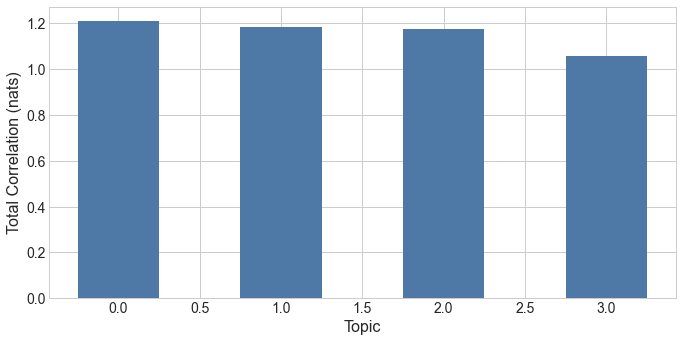

In [213]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

"I'm not a huge fan of this (doesn't work that well, I think). I prefer taking the clean topics (e.g., 3 topics), anchoring them to hold them more or less fixed (next slide), then re-running CorEx with extra topics (e.g., 6), to see if any new clean topics come out. 
  * Repeat the above until topics are clean"

### Ways to Use CorEx
  * Use your domain knowledge (use anchors)
  * Use low anchor strength (2) in order to have as broad a match as possible

In [214]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
                anchors=[['sell'], 
                         ['ath'], 
                         ['prediction'], 
                         ['price'],
                         ['buy'], 
                         ['hodl']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: sell,ltc,eth,xrp,bch,ratio,btc,beta,bot,performed
1: ath,size,blk,wght,kbtxs,pool,tue,block,government,light
2: prediction,telegram,sec,accurate,status,predictions,min,channel,join,sur
3: price,current,trend,days,going,chart,record,amid,hours,volume
4: buy,people,money,know,amp,think,like,world,way,need
5: del,precio,mxn,actual,desde,vende,aqu,hodl,rewards,casino


### Ways to Use CorEx
  * __Highlight smaller topics that may be otherwise hidden by larger topics (use anchors)__
  * Use high anchor strength (5+) in order to force topics
    * Likely means that there will be fewer documents matched to the topic

In [215]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
#Why the double brackets??
                anchors=[['buy', 'sell'], 'prediction'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: buy,sell,ratio,performed,earned,bot,invested,beginning,pair,trades
1: prediction,telegram,min,accurate,status,predictions,channel,trend,sec,join
2: short,bitmex,long,whale,amp,markets,bounce,people,stock,ltc
3: que,del,precio,los,mxn,desde,las,actual,vende,para
4: project,free,good,sur,trading,actu,des,team,link,later
5: wallet,blockchain,haven,safe,btc,users,trezor,hardware,secure,block


### Ways to Use CorEx
  * __To see how the same word can be used in different topics (use anchors)__
  * Anchor the same word multiple times

In [216]:
topic_model = ct.Corex(n_hidden=8, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
                anchors=[['sell'], ['sell'], ['sell'], ['sell']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: sell,ltc,eth,xrp,btc,bch,prices,usd,usdt,update
1: sell,que,los,las,una,como,der,und,ist,mercado
2: sell,ratio,beta,total,bot,performed,invested,earned,pair,trades
3: sell,beginning,info,buy,shorts,longs,iets,dan,untuk,yang
4: like,good,project,support,team,recent,think,hit,great,believe
5: block,sur,les,blockchain,platform,use,actu,digital,crypto,des
6: safe,know,amp,stock,value,haven,people,money,gold,need
7: current,trend,predictions,whale,accurate,channel,status,min,telegram,sec


### Resources and other ways to use CorEx

Take a look at the Github rep:
  * Main page: https://github.com/gregversteeg/corex_topic
  * Example notebook (MUST READ!): https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb

## Word2Vec and GloVe
Word2Vec is a very powerful and useful word embedding method. Gensim comes equipped with ways for us to train our own Word2Vec model, or load in a pre-trained word2vec model.

In [217]:
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in df_tweets['tokens']] 

In [218]:
# size refers to the desired dimension of our word vectors
# window refers to the size of our context window
# why am I using skipgram?
# sg means that we are using the Skip-gram architecture

model1 = gensim.models.Word2Vec(tokenized_docs, size=5, window=2,min_count=1, sg=1)

In [219]:
model1.most_similar('btc' ,topn=10)

[('coinbase', 0.995563268661499),
 ('pair', 0.9921392202377319),
 ('arms', 0.9919389486312866),
 ('mai', 0.9906209707260132),
 ('nough', 0.990347146987915),
 ('upstairs', 0.9900001287460327),
 ('yayn', 0.9885592460632324),
 ('southeast', 0.9884265065193176),
 ('encuentro', 0.9881598949432373),
 ('personnel', 0.9880771636962891)]

In [220]:
model1.similarity('btc','hodl')

0.843982

In [221]:
# Positive Negative Similar Words
model1.most_similar(positive=['btc', 'buy'], negative=['sell'])

[('try', 0.9973786473274231),
 ('etmeliyim', 0.9952789545059204),
 ('dster', 0.9943414926528931),
 ('dal', 0.9924434423446655),
 ('mielt', 0.991824209690094),
 ('surveiller', 0.9911242723464966),
 ('arms', 0.9909156560897827),
 ('mai', 0.9901562929153442),
 ('phillip', 0.9887065887451172),
 ('analyze', 0.9885692596435547)]

In [222]:
model1.most_similar(positive=['btc', 'buy'], topn=5)

[('sell', 0.9990990161895752),
 ('try', 0.9980844259262085),
 ('dster', 0.9950941801071167),
 ('etmeliyim', 0.9946283102035522),
 ('dal', 0.993600606918335)]

Training our own model with word2vec is pretty cool, but it requires us to have a large corpus of data.

Fortunately, research groups at Stanford and Google have made their pre-trained word embeddings publicly available for us to use!

Google's word2vec: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

GloVe: https://nlp.stanford.edu/projects/glove/

Just note that these model's will require ~4 GB of RAM to fit in memory

In [1]:
# We are using vectors of length 200. Lesser vectors lessen processing time.
glove_file = './../Data/word_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt'
tmp_file = get_tmpfile("glove_word2vec.txt")

# call glove2word2vec script
# default way (through CLI): python -m gensim.scripts.glove2word2vec --input <glove_file> --output <w2v_file>
glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)

In [2]:
type(model.vocab)

dict

In [3]:
# Number of Vectors
len(model.vocab.keys())

1193514

In [4]:
# Size of the Vectors
model.vector_size

200

## Question 2
**Exploring Word2Vec Vectors**
* Print out a few word vectors from the Google set
* Print out the similarity between the following pairs (feel free to experiment with more if you like):
  * baseball, bat
  * baseball, ocean
  * bat, fly
* What sorts of patterns do you notice?  Where does it succeed?  Where does it fail?  How might one improve it?
* Print out the most similar words to the following words:
  * baseball
  * president
* Print out words similar to the positive words and dissimilar to the negative words for the following positive/negative groups:
* Print out the words that don't match the others in each of the following groups:

In [6]:
# Word Vectors
model.word_vec('bitcoin')

array([-0.074393 ,  0.10186  , -0.049351 , -0.53166  ,  0.25706  ,
       -0.5222   ,  0.17046  , -0.18893  ,  0.28897  , -0.12184  ,
        0.12619  ,  0.10341  , -1.0856   , -0.34959  ,  0.069433 ,
       -0.093725 , -0.33688  ,  0.46042  ,  0.65069  , -0.48376  ,
       -0.30007  ,  0.1678   ,  0.57996  , -0.10948  , -0.66832  ,
        0.7577   ,  0.41654  , -0.052058 , -0.59622  , -0.087796 ,
        0.4622   , -0.013795 , -0.44185  , -0.40651  ,  0.92432  ,
       -0.43312  , -0.012119 , -0.16346  ,  0.011646 , -0.33362  ,
        0.1437   ,  0.15696  ,  0.039093 ,  0.079893 ,  0.84927  ,
       -0.6614   , -0.76457  , -0.33192  ,  0.18674  ,  0.79411  ,
        0.57455  ,  0.1395   , -0.52864  ,  0.38603  ,  0.16032  ,
        0.52374  ,  0.49671  ,  0.37611  , -0.40939  ,  0.11506  ,
       -0.31058  , -0.2225   ,  0.34445  ,  0.01097  ,  0.64503  ,
       -0.063416 ,  0.4637   ,  0.29511  , -0.48942  ,  0.78048  ,
        0.52689  , -0.36406  ,  0.04378  ,  0.26221  ,  0.1767

In [7]:
# Pairwise Similarity
# Word2Vec captures some interesting similarities between words, such as the relationship between **bitcoin --> crypto**
model.similarity('bitcoin', 'crypto')

0.44594115

* Word Sense Disambiguation

In [8]:
# Most similar words
model.similar_by_word('bitcoin')

[('bitcoins', 0.6961264610290527),
 ('gox', 0.613304853439331),
 ('currency', 0.5955000519752502),
 ('exchange', 0.586264431476593),
 ('btc', 0.5816957354545593),
 ('dogecoin', 0.5782854557037354),
 ('trading', 0.5429692268371582),
 ('paypal', 0.5402452349662781),
 ('mining', 0.5222750902175903),
 ('commodity', 0.520323634147644)]

In [10]:
# Positive Negative Similar Words
model.most_similar(positive=['bit', 'gox'], negative=['scheme'])

[('abit', 0.4347763657569885),
 ('alittle', 0.41617801785469055),
 ('mt.', 0.4082877039909363),
 ('slightly', 0.401253879070282),
 ('little', 0.3616727590560913),
 ('pain', 0.34664636850357056),
 ('calmed', 0.3462069034576416),
 ('sad', 0.34080612659454346),
 ('angry', 0.340280145406723),
 ('much', 0.336826354265213)]

In [11]:
# Positive Negative Similar Words
model.most_similar(positive=['bit', 'gox'], negative=['scheme'],)

[('abit', 0.4347763657569885),
 ('alittle', 0.41617801785469055),
 ('mt.', 0.4082877039909363),
 ('slightly', 0.401253879070282),
 ('little', 0.3616727590560913),
 ('pain', 0.34664636850357056),
 ('calmed', 0.3462069034576416),
 ('sad', 0.34080612659454346),
 ('angry', 0.340280145406723),
 ('much', 0.336826354265213)]

It can also detect words that don't belong in a sequence:

In [14]:
# Words that don't match
model.doesnt_match(['breakfast', 'dinner'])

'breakfast'

## Question 3


word similarities

In [17]:
# Comparing via Cosine Similarity
model.n_similarity(['bitcoin', 'crypto'], ['blockchain', 'crypto'])

0.73180556

In [21]:
# Comparing via Word Mover's Distance

model.wmdistance(['bitcoin', 'crypto'], ['blockchain', 'crypto'])

3.9035424510822296

In [23]:
model.wmdistance("Bitcoin is the best of cryptocurrency".lower().split(), 
                        "Ethereum is the best of cryptocurrency".lower().split())

1.427231936853526

Other Resources:      
Doc2Vec extends the word2vec algorithm to larger blocks of texts (paragraphs, documents, articles):    
- https://radimrehurek.com/gensim/models/doc2vec.html
- http://learningaboutdata.blogspot.com/2014/06/plotting-word-embedding-using-tsne-with.html
- https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis
- https://radimrehurek.com/gensim/models/word2vec.html
- https://www.tensorflow.org/tutorials/word2vec